In [ ]:
import sys

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import torch

# import some common libraries
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.builtin_meta import COCO_CATEGORIES


def cv2_imshow( im ):
    cv2.imshow('',im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# print(COCO_CATEGORIES)
things = MetadataCatalog.get("coco_2017_train").thing_classes
from actorlogger import ActorLogger, Frame

In [ ]:
##### CAMERA CALIBRATION CONFIG - this configuration comes from how we set up Cameras in CARLA
baseline_F = 0.8 # 80cm on top car
baseline_LC = np.sqrt([0.2*0.2 *2])[0] # left corner
baseline_RC = np.sqrt([0.2*0.2 *2])[0] # right corner
baseline_L = 0.5 # left side
baseline_R = 0.5 # right side

# translation matrices
# translate_F

# camera properties
fov=90
W=1280
H=720

fov = fov / 360. * 2. * np.pi
f = W / (2. * np.tan(fov / 2.))  # focus length

In [4]:
########### CONFIGURE DETECTRON
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

RuntimeError: CUDA error: out of memory

In [24]:
path = "/home/najib/Thesis/Rendering/" + str(4)

In [25]:
imgL = cv2.imread(path + '/out/132FL.jpg')
imgR = cv2.imread(path + '/out/132FR.jpg')

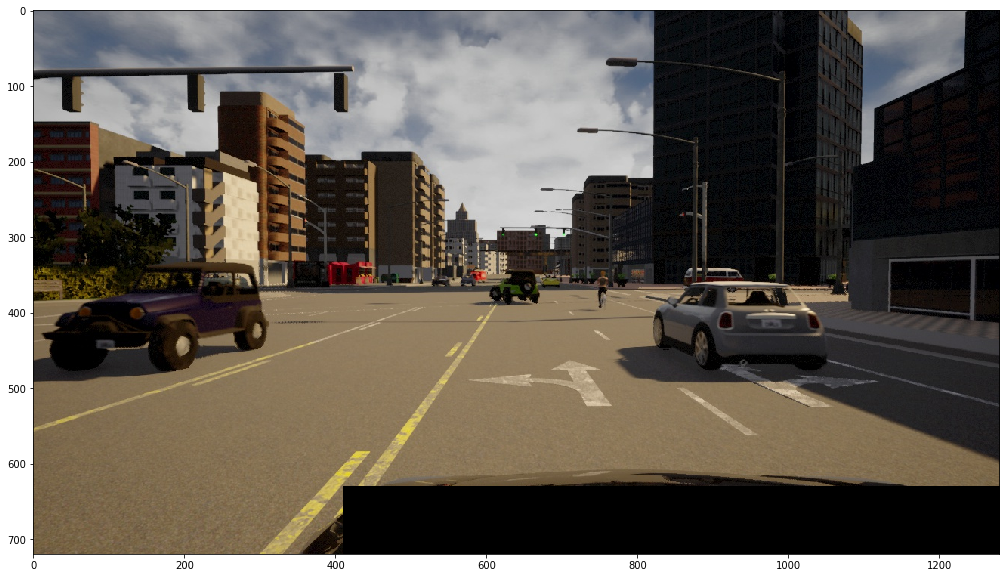

In [26]:
imgR[630:H, 0:880] = [15,15,15]
imgL[630:H, 410:W] = [0,0,0]
plt.figure(figsize=(20,10))
plt.imshow(imgL[:,:,::-1]) # bgr to rgb
#cv2_imshow(im)

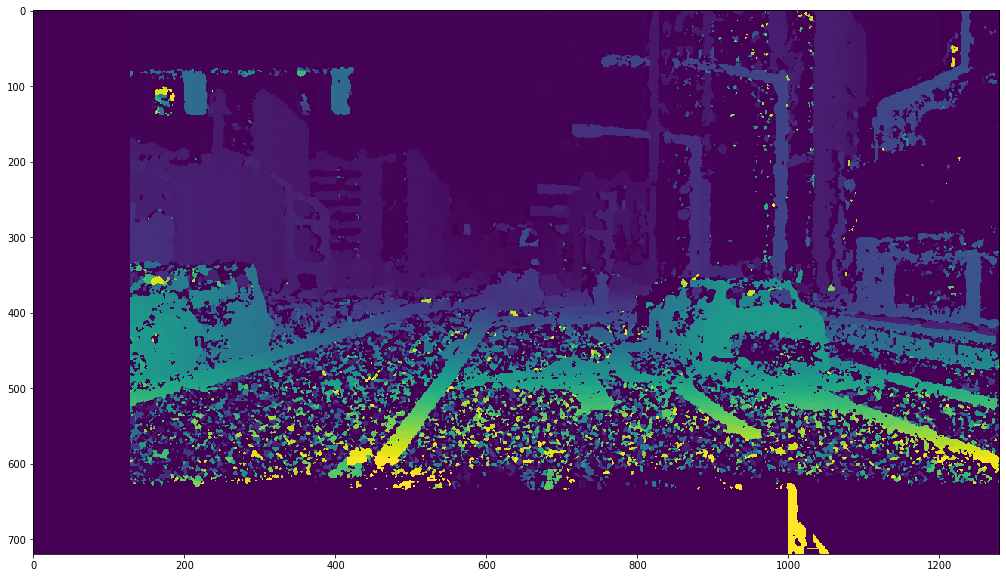

In [27]:
num_disp = 128
window_size = 11
stereo = cv2.StereoSGBM_create(numDisparities = num_disp, blockSize = window_size )

stereo.setUniquenessRatio(5)

grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
disp = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
disparity = (disp)

plt.figure(figsize=(20,10))
plt.imshow(disparity)
plt.show()
#cv2_imshow(disp_map)

In [28]:

outputs = predictor(imgL)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
# outputs["instances"].pred_boxes[0]
# outputs["instances"].pred_classes[0]

In [29]:
mask = outputs["instances"].pred_masks[0]
masked = torch.tensor(disparity)[mask]
nonnegative = masked > 0  # negative values in depth map mean unmatched regions
normdist = masked[nonnegative].mean()
print(normdist)

tensor(59.8576)


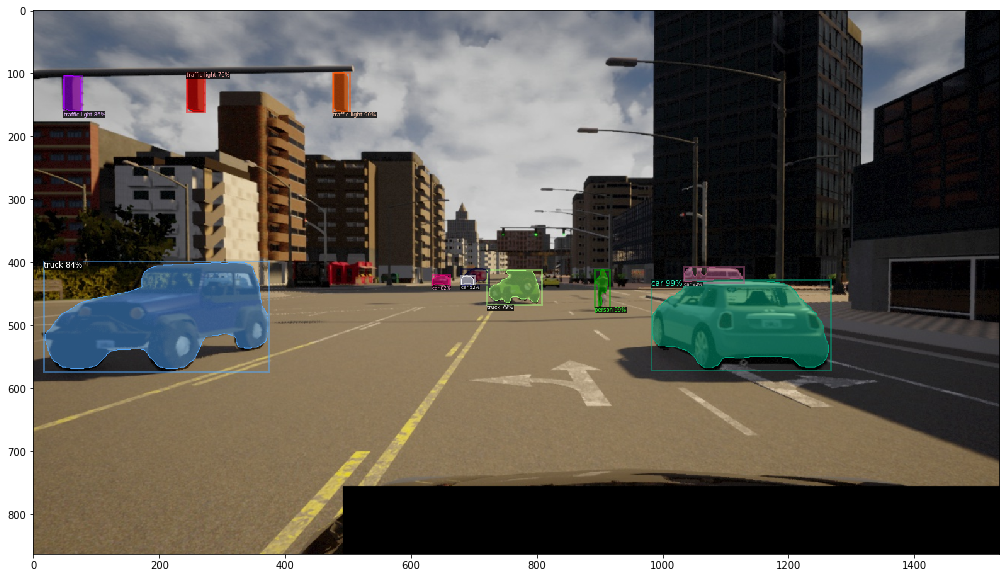

In [10]:
v = Visualizer(imgL[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
detim = v.get_image()

plt.figure(figsize=(20,10))
plt.imshow(detim)
#cv2_imshow(detim[:, :, ::-1])

In [1]:
imgL = cv2.imread('/home/najib/Thesis/Rendering/1/out/114FL.jpg')
imgR = cv2.imread('/home/najib/Thesis/Rendering/1/out/114FR.jpg')
outputs = predictor(imgL)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
# outputs["instances"].pred_boxes[0]

i =2
[[x, y]] = outputs["instances"].pred_boxes[i].get_centers()
print(x, y)

grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
disp = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
disparity = (disp)

mask = outputs["instances"].pred_masks[i]
masked = torch.tensor(disparity)[mask]
nonnegative = masked > 0  # negative values in depth map mean unmatched regions
normdist = masked[nonnegative].mean()

difference = normdist

dx = x - W/2
dy = y - H/2
z = torch.tensor(f*baseline_F)/difference
x = dx*z/f
y = dy*z/f
  
print(x,y,z)
print(things[outputs["instances"].pred_classes[i]])

NameError: name 'cv2' is not defined